In [1]:
import sys
sys.path.append("../../")

from torch.utils.data import DataLoader
from enformer_pytorch import Enformer, from_pretrained

from MPRA_predict.utils import *
from MPRA_predict.datasets import *

/home/hxcai/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_pred(model, test_data_loader, device):
    model = model.to(device)
    y_pred = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_data_loader):
            if isinstance(batch, (list, tuple)):
                x, y = batch
            else:
                x = batch
            if isinstance(x, dict):
                x = x['seq']
            else:
                x = x

            x = x.to(device)
            output = model(x)['human']
            y_pred.append(output.cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)
    return y_pred


def get_pred_rc(model, test_data_loader, device):
    model = model.to(device)
    y_pred = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_data_loader):
            if isinstance(batch, (list, tuple)):
                x, y = batch
            else:
                x = batch
            if isinstance(x, dict):
                x = x['seq']
            else:
                x = x

            x = x.to(device)
            x_rc = onehots_rc(x).to(device)
            output = (model(x)['human'] + model(x_rc)['human']) / 2
            y_pred.append(output.cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)
    return y_pred

# 实验1：random_seed的影响

# 结论1：Enformer不受random_seed的影响

# 实验2：batch_size的影响

In [3]:
for batch_size in [1,2,4]:
    set_seed(0)
    trained_model_path = 'Enformer'
    device = 'cuda:0'
    model = from_pretrained(trained_model_path)
    dataset = SeqLabelDataset(
        data_path='../../data/SirajMPRA/SirajMPRA_100.csv',
        seq_column='seq', padding=True, padded_length=196_608, N_fill_value=0)
    test_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    y_pred = get_pred(model, test_data_loader, device)

    torch.cuda.empty_cache()
    np.save(f'data/Enformer_Siraj_pred_batch_size={batch_size}.npy', y_pred)

set all labels to 0


100%|██████████| 100/100 [00:11<00:00,  8.99it/s]


set all labels to 0


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


set all labels to 0


100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


In [4]:
y_pred_list = []
for batch_size in [1,2,4]:
    y_pred = np.load(f'data/Enformer_Siraj_pred_batch_size={batch_size}.npy')
    print(y_pred.shape)
    y_pred_list.append(y_pred)

y_pred_list = np.array(y_pred_list).reshape(-1)
print(np.corrcoef(y_pred_list))

(100, 896, 5313)
(100, 896, 5313)
(100, 896, 5313)
1.0


# 实验3：target_length的影响

In [ ]:
for target_length in [2,4,896]:
    set_seed(0)
    trained_model_path = 'Enformer'
    device = 'cuda:0'
    
    model = from_pretrained(trained_model_path, target_length=target_length)
    dataset = SeqLabelDataset(
        data_path='../../data/SirajMPRA/SirajMPRA_100.csv',
        seq_column='seq', padding=True, padded_length=196_608, N_fill_value=0)
    test_data_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
    y_pred = get_pred(model, test_data_loader, device)

    torch.cuda.empty_cache()
    np.save(f'data/Enformer_Siraj_pred_target_length={target_length}.npy', y_pred)

set all labels to 0


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


set all labels to 0


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


set all labels to 0


100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


In [ ]:
y_pred_list = []

y_pred = np.load(f'data/Enformer_Siraj_pred_target_length=2.npy')
print(y_pred.shape)
y_pred_list.append(y_pred)

y_pred = np.load(f'data/Enformer_Siraj_pred_target_length=4.npy')
print(y_pred.shape)
y_pred_list.append(y_pred[:, 1:3])

y_pred = np.load(f'data/Enformer_Siraj_pred_target_length=896.npy')
print(y_pred.shape)
y_pred_list.append(y_pred[:, 447:449])

y_pred_list = np.array(y_pred_list)

print(np.corrcoef(y_pred_list.reshape(y_pred_list.shape[0], -1)))

(100, 2, 5313)
(100, 4, 5313)
(100, 896, 5313)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


# 结论2：target_length基本不影响速度和结果, 轻微影响显存

# 实验3：padding长度的影响

In [ ]:
for padded_length in [200, 256, 2**10, 2**12, 2**14, 2**16, 131072, 196608, 393216]:

    set_seed(0)
    trained_model_path = 'Enformer'
    device = 'cuda:0'

    model = from_pretrained(trained_model_path, target_length=2)
    dataset = SeqLabelDataset(
        data_path='../../data/SirajMPRA/SirajMPRA_100.csv',
        seq_column='seq', padding=True, padded_length=padded_length, N_fill_value=0)
    test_data_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
    y_pred = get_pred(model, test_data_loader, device)

    torch.cuda.empty_cache()
    np.save(f'data/Enformer_Siraj_pred_padded_length={padded_length}.npy', y_pred)

set all labels to 0


100%|██████████| 25/25 [00:00<00:00, 99.39it/s] 


set all labels to 0


100%|██████████| 25/25 [00:00<00:00, 98.82it/s] 


set all labels to 0


100%|██████████| 25/25 [00:00<00:00, 89.41it/s]


set all labels to 0


100%|██████████| 25/25 [00:00<00:00, 60.30it/s]


set all labels to 0


100%|██████████| 25/25 [00:00<00:00, 27.78it/s]


set all labels to 0


100%|██████████| 25/25 [00:03<00:00,  7.77it/s]


set all labels to 0


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


set all labels to 0


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


set all labels to 0


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


In [ ]:
y_pred_list = []
for padded_lengthgth in [200, 256, 2**10, 2**12, 2**14, 2**16, 131072, 196608, 393216]:
    y_pred = np.load(f'data/Enformer_Siraj_pred_padded_length={padded_length}.npy')
    print(y_pred.shape)
    y_pred_list.append(y_pred)

y_pred_list = np.array(y_pred_list)
np.set_printoptions(linewidth=120)
print(np.corrcoef(y_pred_list.reshape(y_pred_list.shape[0], -1)))

(100, 2, 5313)
(100, 2, 5313)
(100, 2, 5313)
(100, 2, 5313)
(100, 2, 5313)
(100, 2, 5313)
(100, 2, 5313)
(100, 2, 5313)
(100, 2, 5313)
[[1.         0.92467058 0.70675221 0.54787606 0.47998118 0.47357955 0.47563519 0.47677916 0.47841856]
 [0.92467058 1.         0.7308459  0.50474856 0.41220343 0.40093485 0.4011001  0.40124493 0.40080858]
 [0.70675221 0.7308459  1.         0.82742689 0.7136997  0.69527044 0.69122841 0.68871428 0.68161768]
 [0.54787606 0.50474856 0.82742689 1.         0.95597091 0.93802279 0.93217885 0.92850557 0.91969387]
 [0.47998118 0.41220343 0.7136997  0.95597091 1.         0.99544073 0.99197435 0.98954859 0.9832262 ]
 [0.47357955 0.40093485 0.69527044 0.93802279 0.99544073 1.         0.99928205 0.99824088 0.99432412]
 [0.47563519 0.4011001  0.69122841 0.93217885 0.99197435 0.99928205 1.         0.99975692 0.99744625]
 [0.47677916 0.40124493 0.68871428 0.92850557 0.98954859 0.99824088 0.99975692 1.         0.99872106]
 [0.47841856 0.40080858 0.68161768 0.91969387 0.9

<Axes: >

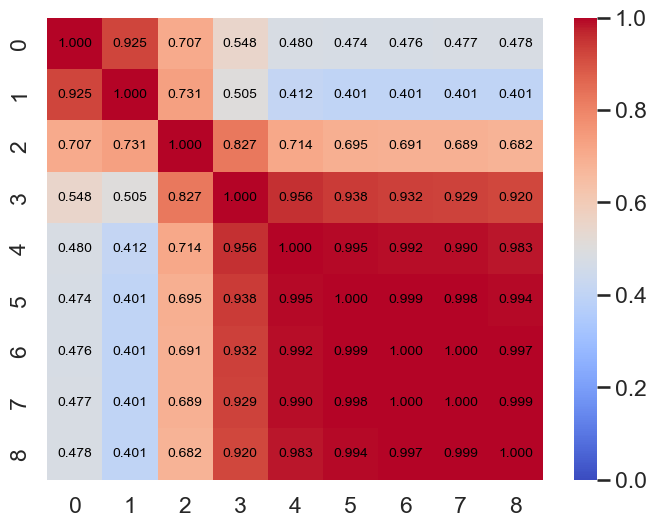

In [ ]:
sns.heatmap(np.corrcoef(y_pred_list.reshape(y_pred_list.shape[0], -1)),
            cmap="coolwarm", vmin=0, vmax=1, annot=True, fmt=".3f", annot_kws={"size": 10, 'color': 'black'})

In [ ]:
print(y_pred_list.mean(axis=(1,2,3)))

[1.0454036  1.0852852  1.1676197  1.0250596  0.9798617  0.97276527 0.97528386 0.9762635  0.97524226]


# 结论3：pad显著影响结果

pad=200和pad=256结果差不太多(r~0.9)

但是和pad=196608差别很大(r~0.4)

平均信号强度基本不变

N=0和N=0.25结果差别很大(r~0.6)

# 实验4： 比较genome padding和N padding

In [ ]:
dataset = BedDataset(
    bed_path='../../data/SirajMPRA/SirajMPRA_100.csv', 
    genome_path='../../../../genome/hg19.fa')

In [ ]:
set_seed(0)
trained_model_path = 'Enformer'
device = 'cuda:0'

model = from_pretrained(trained_model_path, target_length=2)
dataset = BedDataset(
    bed_path='../../data/SirajMPRA/SirajMPRA_100.csv', 
    genome_path='../../../../genome/hg19.fa',
    genome_window_size=196608)

test_data_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
y_pred = get_pred(model, test_data_loader, device)

torch.cuda.empty_cache()
np.save(f'data/Enformer_Siraj_pred_bed_dataset.npy', y_pred)

  0%|          | 0/25 [00:00<?, ?it/s]/home/hxcai/cell_type_specific_CRE/MPRA_predict/notebooks/pretrained_models/../../MPRA_predict/datasets/BedDataset.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float)
/home/hxcai/cell_type_specific_CRE/MPRA_predict/notebooks/pretrained_models/../../MPRA_predict/datasets/BedDataset.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float)
/home/hxcai/cell_type_specific_CRE/MPRA_predict/notebooks/pretrained_models/../../MPRA_predict/datasets/BedDataset.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

KeyboardInterrupt: 

In [ ]:
y_pred = np.load(f'data/Enformer_Siraj_pred_bed_dataset.npy')
print(y_pred.shape)

y_pred_2 = np.load(f'data/Enformer_Siraj_pred_padded_length=196608.npy')
print(y_pred_2.shape)

(y_pred == y_pred_2).all()

(100, 2, 5313)
(100, 2, 5313)


False

In [ ]:
y_pred

array([[[0.49641743, 0.53111815, 0.6526666 , ..., 0.03282204,
         0.24221255, 0.39656678],
        [0.35675162, 0.35826644, 0.5343172 , ..., 0.07466529,
         0.63177264, 0.998656  ]],

       [[0.49641743, 0.53111815, 0.6526666 , ..., 0.03282204,
         0.24221255, 0.39656678],
        [0.35675162, 0.35826644, 0.5343172 , ..., 0.07466529,
         0.63177264, 0.998656  ]],

       [[0.05341086, 0.04149767, 0.03522886, ..., 0.00368416,
         0.0114732 , 0.00979407],
        [0.05142899, 0.04179503, 0.0392975 , ..., 0.00330846,
         0.01074063, 0.00943512]],

       ...,

       [[0.02212196, 0.02886742, 0.03534057, ..., 0.00226836,
         0.00922884, 0.00435526],
        [0.08546597, 0.09543043, 0.11159252, ..., 0.00503291,
         0.01137636, 0.00578577]],

       [[0.12694344, 0.13454068, 0.16969986, ..., 0.00334302,
         0.00774447, 0.00645422],
        [0.17051901, 0.18340878, 0.23938677, ..., 0.00396433,
         0.01234872, 0.00817071]],

       [[0.126943